In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np
from random import randint

In [2]:
IMAGE_DIR = "./sample-labelled-images"
SAVE_DIR = "./sample-labelled-images/synthetic-data"

In [3]:
def save_labels_as_xml(labels, image_name, save_folder, template_path="./template.xml"):
    
    annotation = ET.parse(template_path).getroot()
    annotation.find("path").text += "/" + image_name
    annotation.find("filename").text = image_name + ".jpg"
    for box in labels:
        object = ET.SubElement(annotation, "object")

        name = ET.SubElement(object, "name")
        name.text = "tag"
        pose = ET.SubElement(object, "pose")
        pose.text = "Unspecified"
        trunc = ET.SubElement(object, "truncated")
        trunc.text = "0"
        diff = ET.SubElement(object, "difficult")
        diff.text = "0"

        bndbox = ET.SubElement(object, "bndbox")

        xmin = ET.SubElement(bndbox, "xmin")
        xmin.text = str(box[0])
        ymin = ET.SubElement(bndbox, "ymin")
        ymin.text = str(box[1])
        xmax = ET.SubElement(bndbox, "xmax")
        xmax.text = str(box[2])
        ymax = ET.SubElement(bndbox, "ymax")
        ymax.text = str(box[3])
    tree = ET.ElementTree()
    tree._setroot(annotation)
    tree.write(os.path.join(save_folder, image_name + ".xml"), encoding="utf-8")

In [4]:
# seperating images between those used as background and those containing tags

labels = [e for e in os.listdir(IMAGE_DIR) if e[-4:]==".xml"]
images = [e for e in os.listdir(IMAGE_DIR) if e[-4:].lower()==".jpg"]

tags = []
bg_images = []
for image in images:
    xml_file = image[:-4]+".xml"
    if xml_file in labels:

        annotation = ET.parse(os.path.join(IMAGE_DIR, xml_file))
        if annotation.find("object") is not None:
            tags.append(os.path.join(IMAGE_DIR, image))
        else:
            bg_images.append(os.path.join(IMAGE_DIR, image))
    else:
        bg_images.append(os.path.join(IMAGE_DIR, image))

In [5]:
# Example: extracting a tag from an image
annotation = ET.parse(np.random.choice(tags)[:-4]+".xml")
annotation.find("object").find("bndbox").find("xmax").text
xmin = int(annotation.find("object").find("bndbox").find("xmin").text)
xmax = int(annotation.find("object").find("bndbox").find("xmax").text)
ymin = int(annotation.find("object").find("bndbox").find("ymin").text)
ymax = int(annotation.find("object").find("bndbox").find("ymax").text)

img = cv2.imread(os.path.join(IMAGE_DIR, annotation.find("filename").text))
real_tag = img[ymin:ymax, xmin:xmax]

(-0.5, 639.5, 639.5, -0.5)

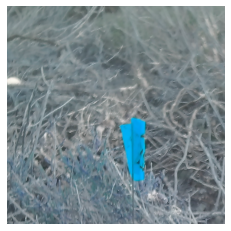

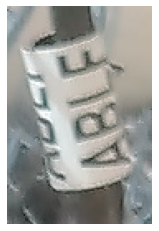

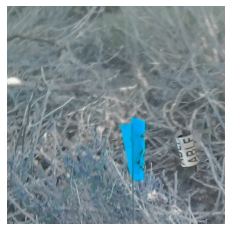

In [6]:
# Example: seamless cloning a tag onto a background image 

from random import randint

bg = cv2.imread(np.random.choice(bg_images))

bg_height, bg_width, channels = bg.shape
bg_cut_x, bg_cut_y = randint(0, bg_height - 639), randint(0, bg_width - 639)
bg = bg[bg_cut_x:bg_cut_x+640, bg_cut_y:bg_cut_y+640]

tag_height, tag_width, _ = real_tag.shape
paste_x = randint(tag_height//2, 640-tag_height//2)
paste_y = randint(tag_width//2, 640 - tag_width//2)

mask = np.ones(real_tag.shape, real_tag.dtype) * 255
res = cv2.seamlessClone(real_tag.astype(np.float32), bg, mask, (paste_y, paste_x), cv2.NORMAL_CLONE)


plt.figure()
plt.imshow(bg)
plt.axis("off")
plt.figure()
plt.imshow(real_tag)
plt.axis("off")
plt.figure()
plt.imshow(res)
plt.axis("off")

In [7]:
# Running the above example several times and saving both resulting images and labels

from random import randint
n_images_created = 0
n_images_max = 3 #number of synthetic images to create

for i in range(n_images_max):
    # choosing a background
    bg_fn = np.random.choice(bg_images)
    bg = cv2.imread(bg_fn)
    
    # cutting a tag from real photos
    tag_fn = np.random.choice(tags)
    annotation = ET.parse(tag_fn[:-4]+".xml")
    xmin = int(annotation.find("object").find("bndbox").find("xmin").text)
    xmax = int(annotation.find("object").find("bndbox").find("xmax").text)
    ymin = int(annotation.find("object").find("bndbox").find("ymin").text)
    ymax = int(annotation.find("object").find("bndbox").find("ymax").text)
    real_tag = cv2.imread(tag_fn)
    real_tag = real_tag[ymin:ymax, xmin:xmax]
    
    bg_height, bg_width, channels = bg.shape
    bg_cut_x, bg_cut_y = randint(0, bg_height - 639), randint(0, bg_width - 639)
    bg = bg[bg_cut_x:bg_cut_x+640, bg_cut_y:bg_cut_y+640]

    tag_height, tag_width, _ = real_tag.shape
    paste_x = randint(tag_height//2, 640-tag_height//2)
    paste_y = randint(tag_width//2, 640 - tag_width//2)

    mask = np.ones(real_tag.shape, real_tag.dtype) * 255
    res = cv2.seamlessClone(real_tag.astype(np.float32), bg, mask, (paste_y, paste_x), cv2.NORMAL_CLONE)
    #labelled_res = cv2.rectangle(res, (paste_y - tag_width//2, paste_x - tag_height//2), 
    #                             (paste_y + tag_width//2, paste_x + tag_height//2), (0,255,0), 2)
    ymin, xmin = (paste_y - tag_width//2, paste_x - tag_height//2)
    ymax, xmax = (paste_y + tag_width//2, paste_x + tag_height//2)
    
    syn_fn = "syn_"+str(i)
    cv2.imwrite(os.path.join(SAVE_DIR, syn_fn+".jpg"), res)
    save_labels_as_xml([(ymin, xmin, ymax, xmax)], syn_fn, SAVE_DIR, template_path="./scripts/preprocessing/template.xml")
    print(i+1, 'synthetic images created/', n_images_max, end="\r")
